In [10]:
from katpoint import katpoint
import coordinate as coord
import sys
import numpy as np


In [11]:
#This class is a copy from the Mosaic code https://gitlab.mpifr-bonn.mpg.de/wchen/Beamforming/tree/master/mosaic

class DelayPolynomial(object):
    """
    Class for generation of  delay polynomial

    arguments:
    antennas -- a list of antenna objects or coordinate in csv format
    targets -- a list of beam location in equatorial coordinates
    frequencies -- a list of frequencies on which the polynomail is calculated in Hz
    reference -- the reference antenna for delay calculation
    """
    def __init__(self, antennas, bore_sight, targets, reference):
        """
        constructor of the Delay Polynomial class.

        """
        self.antennas = antennas
        self.targets = DelayPolynomial.check_targets(targets)
        self.frequency = 1.4e9
        self.reference = reference
        self.bore_sight = DelayPolynomial.check_targets([bore_sight,])[0]
        

    @staticmethod
    def check_targets(targets):
        """
        check the target data type, the arguments will be converted to katpoint
            object if they are not.

        arguments:
        targets -- a list of target objets in the format of
            katpoint target object or set of [longitude, latitude, altitude]

        return:
            targets in katpoint object

        """
        if isinstance(targets[0], katpoint.Target):
            return targets
        else:
            return DelayPolynomial.make_katpoint_target(targets)

    @staticmethod
    def check_time(time):
        """
        check the the data type of the time value. If the values are datetime
            objects, they will be converted to seconds

        arguments:
        time -- epoch seconds or datetime objects

        return:
        time in epoch seconds
        """
        if type(time) != int and type(time) != float:
            return coord.datetimeToEpoch(time)
        else:
            return time

    @staticmethod
    def make_katpoint_target(sources):
        """
        check the the data type of the source. If the values are in (RA, DEC) pair,
        they will be converted to katpoint target object

        arguments:
        source -- source in either (RA, DEC) pairs or katpoint target objects

        return:
        katpoint target objects
        """

        targets = []
        for source in sources:
            target_string = ",".join(['radec',
                            coord.angleToHour(source[0]),
                            coord.angleToDEC(source[1])])
            targets.append(katpoint.Target(target_string))
        return targets

    def get_delay_polynomials(self, epoch, duration=10.0):
        """
        calculate and return the polynomials

        Arguments:
        timestamp -- the observation time in datatime object or epoch seconds
        duration -- the duration in which the polynomial is calcuated

        return:
        polynomials in the order of beam, antenna, (delay, rate)

        """
        timestamp = DelayPolynomial.check_time(epoch)
        antennaObjectList = self.antennas
        timestamp = (timestamp, timestamp + duration)

        target_array = []
        for target in self.targets:
            dc = katpoint.DelayCorrection(self.antennas,
                    self.reference, self.frequency)
            delay, phase = dc.corrections(target, timestamp)
            delayArray = np.array(dict_to_antenna_ordered_list(
                        delay, self.antennas))

            target_array.append(delayArray[:,0,:])
        target_array = np.array(target_array)

        dc = katpoint.DelayCorrection(self.antennas,
            self.reference, self.frequency)
        delay, phase = dc.corrections(self.bore_sight, timestamp)
        bore_sight_delay = np.array(dict_to_antenna_ordered_list(
                    delay, self.antennas))[:,0,:]

        target_array = target_array - bore_sight_delay
        return target_array

def dict_to_antenna_ordered_list(dict_obj, antennas, pol='h'):
    ordered_list = []
    for antenna in antennas:
        antenna_key = "{}{}".format(antenna.name, pol)
        ordered_list.append(dict_obj[antenna_key])

    return ordered_list


In [12]:
#A list of targets to observe
targets = []

ha=":".join(['1','25','46.5336'])
dec=":".join(['-30','42','39.815999'])
target_string=",".join(['radec',ha,dec])
targets.append(katpoint.Target(target_string))

ha=":".join(['1','26','0'])
dec=":".join(['-30','43','0'])
target_string=",".join(['radec',ha,dec])
print(target_string)
targets.append(katpoint.Target(target_string))

ha=":".join(['7','8','9'])
dec=":".join(['-4','5','6'])
target_string=",".join(['radec',ha,dec])
print(target_string)
targets.append(katpoint.Target(target_string))

targets


radec,1:26:0,-30:43:0
radec,7:8:9,-4:5:6


[<katpoint.Target 'Ra: 1:25:46.53 Dec: -30:42:39.8' body=radec at 0x1a0bf5ca0>,
 <katpoint.Target 'Ra: 1:26:00.00 Dec: -30:43:00.0' body=radec at 0x1a0bf5c40>,
 <katpoint.Target 'Ra: 7:08:09.00 Dec: -4:05:06.0' body=radec at 0x1a0bf5eb0>]

In [13]:
#Default boresight is at ("1:25:46.5336", "-30:42:39.815999")
ha=":".join(['1','25','46.5336'])
dec=":".join(['-30','42','39.815999'])
target_string=",".join(['radec',ha,dec])
defaultBoreSight=katpoint.Target(target_string)

In [14]:
#Reference antenna
from coordinate import Antenna
arrayRef = katpoint.Antenna('ref, -30:42:39.8, 21:26:38.0, 1035.0')
arrayRef.position_wgs84

(-0.5360090362073407, 0.3742664655429396, 1035.0)

In [15]:
#Load in antennas 
"""
    Need a list of antenna objects or coordinate in csv format
    katpoint.Antenna class says that the format for a fully-specified antenna should be: 
    'FF2, -30:43:17.3, 21:24:38.5, 1038.0, 12.0, 86.2 25.5 0.0, -0:06:39.6 0 0 0 0 0 0:09:48.9, 1.16'

"""
import csv
ants=[]
with open('antenna.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    for row in data:
         ants.append(katpoint.Antenna(', '.join(row)))

print(ants[0])

m000: 13-m dish at ENU offset [  -8.254  -207.2925    1.209 ] m from lat -30:42:39.8, long 21:26:38.0, alt 1035.0 m


In [16]:
#provide a random time for now
test = DelayPolynomial(ants, defaultBoreSight, targets,arrayRef)
time = 1629380016
output = test.get_delay_polynomials(time,duration=2)

In [17]:
#beam, antenna, (delay, rate)
output.shape

(3, 64, 2)

In [18]:
#First beam set to boresight, so all delay should be zero
print(output[0,:,0])

#Second beam 
print(output[1,0:3,0])
print(output[1,0:3,1])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.11415118e-11 -1.26406877e-11  7.57498843e-11]
[2.21459813e-14 1.85179071e-14 2.34496955e-14]


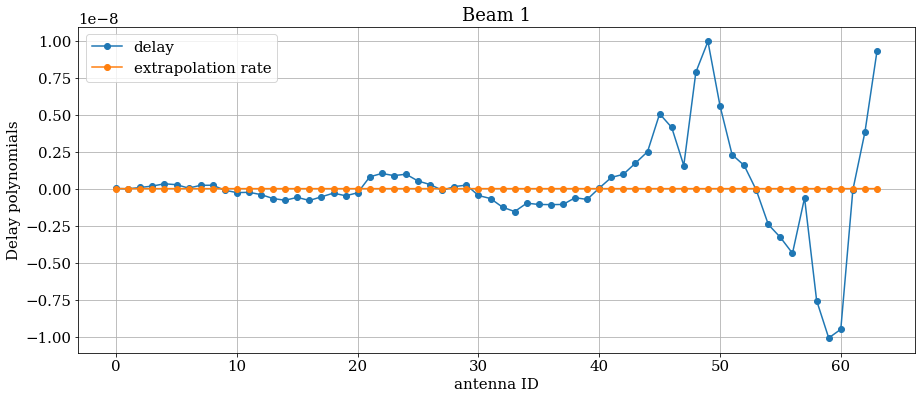

In [19]:
import matplotlib as mpl
import pylab as plt
%matplotlib inline
mpl.rcParams.update({'font.size': 15,'font.family': 'serif'})


fig = plt.figure(figsize=[15,6])
plt.plot(output[1,:,0],marker='o',label='delay')
plt.plot(output[1,:,1],marker='o',label='extrapolation rate')
plt.legend()
plt.title("Beam 1")
plt.xlabel("antenna ID")
plt.ylabel("Delay polynomials")
plt.grid()

Text(0, 0.5, 'Delay')

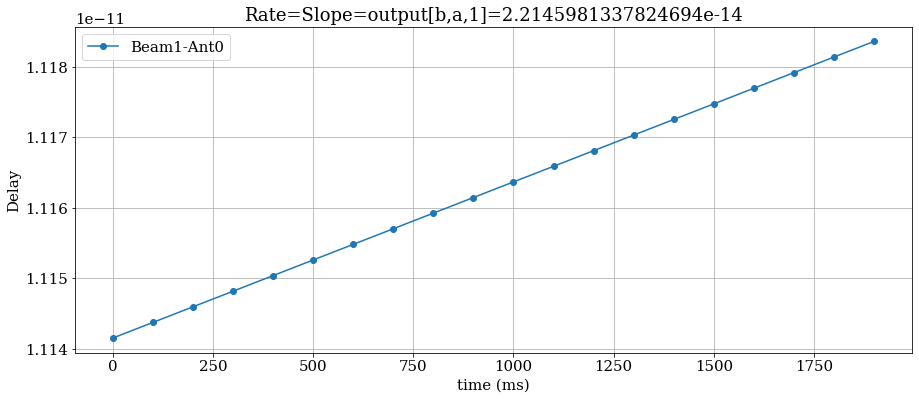

In [20]:
time_step_100ms = np.arange(0,2000,100)
fig = plt.figure(figsize=[15,6])
plt.plot(time_step_100ms,output[1,0,0]+output[1,0,1]/1000.*time_step_100ms,marker="o",label="Beam1-Ant0")
plt.title('Rate=Slope=output[b,a,1]='+str(output[1,0,1]))
plt.legend()
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('Delay')
